## PACF : partial autocorrelation function

We can use partial autocorrelation when we want to compute the correlation between a timeseries and its lags after removing the correlation introduced by intermediate lags

This means that the correlation at $lag(k)$ is high only if it adds additional information, which is not already accounted for by lags prior to it.

* How do we remove the impact of intermediate lags ?
    * We remove the effect of intermediate lags by substracting the linear impact of intermediate lags on $y(t)$ and $y(t-k)$ as given by a linear regression.

<img src='./notes/PACF.jpg'>

### PACF Assumptions
* Time-series must be stationary
    * $Mean$ of time-series must be constant
        * If $mean$ is not constant we can try detrending the data
            * differencing can be employed here, to stabilize the mean
            * we can use moving average to estimate the trend and substract it from the series
            * Advanced methods like $STL$, $LOWESS$ can also be used to estimate the trend
    * $Variance$ of time-series must be constant
        * If $variance$ is not constant we can try $time series-transformation$ to stabilize the variance
            * Methods like Log-transform, Power-transform, Box-Cox can be used
    * $Autocorrelation$
        * The correlation between the timeseries and lagged series should not depend on $time$
            * Unfortunately there are no simple transforms to enforce this behaviour

* We can still use $PACF$ to get some information even if these assumptions are not exactly met, however it can make interpretation difficult.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sktime.utils.plotting import plot_series, plot_correlations, plot_lags


In [2]:
 
def AR_gen(p=1, lag_coef=[0.9], const=0, num_data_points=300):
    rng = np.random.RandomState(seed=42)
    data = np.zeros(num_data_points)
    index = pd.date_range(start='2000-01-01', periods=num_data_points)
    y = pd.Series(data=data, index=index)
    
    for i in range(p, num_data_points):
        y.iloc[i] = const + np.dot(y.iloc[i-p:i].values, lag_coef) + rng.normal(loc=0,scale=1)
    
    return y

In [55]:
def plot_series_acf_pacf(ar, title='TIMESERIES-ACF-PACF'):
    plt.figure(figsize=(16,8))

    grid = gridspec.GridSpec(nrows=2, ncols=2)
    ax_0 = plt.subplot(grid[0, :])
    ax_1 = plt.subplot(grid[1, 0])
    ax_2 = plt.subplot(grid[1, 1])

    plot_series(ar, ax=ax_0)
    ax_0.xaxis.set_ticklabels([])

    plot_acf(ar, ax=ax_1, auto_ylims=True);

    plot_pacf(ar, ax=ax_2, auto_ylims=True);

    plt.suptitle(title, size=20);

## AR PROCESS 

* AR stands for autoregressive.

#### AR(1) process - a time series determined by lag 1 

* Let's create a toy time series where there should be a correlation with lag 1 of the time series.
* We might think that this means there is only a correlation with lag 1 of the time series $y$ but we will see that is not the case. 

In [57]:
ar_1 = AR_gen()
plot_series_acf_pacf(ar_1, 'AR-1 process')

<img src='./plots/AR-1-process--ACF--PACF.png'>

#### So we see that it is not possible to determine that only a lag of 1 that is the most important from the ACF, despite $y_t$ being generated only by $y_{t-1}$. 

#### The partial autcorrelation function (PACF) will help identify that a lag of 1 is important in this scenario.

In [48]:
ar_2 = AR_gen(p=2, lag_coef=[0.6,0.4])

plot_series_acf_pacf(ar_2, 'AR-2 process')

<img src='./plots/AR-2-process--ACF--PACF.png'>

In [49]:
ar_3 = AR_gen(p=3, lag_coef=[0.6, 0.2, 0.1])

plot_series_acf_pacf(ar_3, 'AR-3 process')

<img src='./plots/AR-3-process--ACF--PACF.png'>

## Time series with trend and seasonality

In [53]:
df = pd.read_csv('../../Datasets/example_retail_sales.csv', parse_dates=['ds'], index_col=['ds'])

df.plot(y=['y'])

<img src='./plots/retail-sales-plot.png'>

* #### There is a strong trend component
    * This strong trend causes high correlation at multiple lags
    * ACF show high correlation at multiple lags because of this trend component

<br>

* #### There is an yearly seasonality
    * The yearly season will produce high correlation at multiples of seasonal period
    * We can observe high correlation at mulitples of 12 in the ACF plot
    
<br>


* #### PACF assumptions are not met
    * $mean$ is not stable as series has a strong trend
    * $variance$ is not stable as series has a strong season
    * However, we can still extract useful information from PACF-plot like,  which lags are useful


In [59]:
plot_series_acf_pacf(df['y'], 'Timeseries with trend and seasonality')

<img src='./plots/timeseries-with-trend-and-seasonality.png'>

## Detrend the timeseries

In [66]:
res = lowess(endog=df['y'], exog=range(len(df)), frac=0.1)

plot_series(df['y'])
plt.plot(res[:,1], color='salmon', linewidth=4)
plt.xticks(rotation=20);

<img src='./plots/retail-sales-trend.png'>

In [69]:
retail_detrend = df['y'] - res[:,1]
plot_series(retail_detrend )
plt.xticks(rotation=20);

<img src='./plots/retail-sales-detrended.png'>

In [1]:
plot_series_acf_pacf(retail_detrend, 'Retail sales detrended')

<img src='./plots/retail-sales-detrended-ACF-PACF.png'>

#### The PACF shows a strong lag at 12 but not at multiples of 12 afterwards. This means that most of the predictive information from the seasonal lag is captured at lag 12 as expected!


#### This would suggest that we could create features using a lag of 12 (from the seasonality) and low lags like 1, 2, 3, and 4. The other larger lags such as lag 10, 11, or 13 are more difficult to intrepret. One reason for not including them is that you do not see peaks at multiples of 10, 11, or 13 in the ACF. Also from domain knowledge (this is retail sales) it is highly unlikely that lags beyond 12 months will be that relevant.


## PACF after detrending and deseasonalising the original series

In [74]:
stl = STL(endog=df['y'], seasonal=7, period=12).fit()
stl.plot();

<img src='./plots/retail-STL.png'>

In [76]:
plot_series_acf_pacf(stl.resid, 'Detrended and Deseasonalized')

<img src='./plots/retail-sales-detrended-deseason--ACF--PACF.png'>

We can see that there aren't any large significant lags. There appears to be some significant lags at multiples of 12 which suggests that some part of the seasonal component is still in the residuals and was not perfectly extracted by STL. Practically speaking from looking at this plot there wouldn't be an additional lag beyond 1 or 2 that we would want to add for feature engineering purposes.

## PACF and whitenoise

In [3]:
num_data_points=300

rng = np.random.RandomState(seed=42)

noise = rng.normal(loc=0.0, scale=1.0, size=num_data_points)

noise = pd.Series(noise, index=pd.date_range(start='2000-01-01', periods=num_data_points, freq='D'))

plot_series(noise)
plt.xticks(rotation=30);

<img src='./plots/whitenoise_sktime_plot.png'>

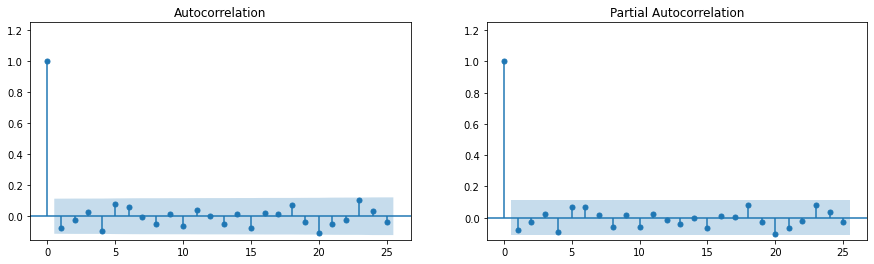

In [10]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4))
plot_acf(noise, auto_ylims=True, ax=ax[0])
plot_pacf(noise, method='ywmle', auto_ylims=True, ax=ax[1]);

* We can clearly saw that there is no significant correlation. As expected from white noise.